# Lecture 5: Model Evaluation and Types of data fitting

MTU Spring 2025

Instructor: Amna Mazen

### Learning outcomes

From this lecture, students are expected to be able to:

- Explain why accuracy is not always the best metric in ML.
- Explain components of a confusion matrix.
- Define precision, recall, and f1-score and use them to evaluate different classifiers.
- Broadly explain macro-average, weighted average.


### Imports

In [ ]:
import os
import sys

sys.path.append("code/.")

import IPython
import matplotlib.pyplot as plt
#import mglearn
import numpy as np
import pandas as pd
from IPython.display import HTML, display
#from plotting_functions import *
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error, r2_score


#from utils import *

%matplotlib inline
pd.set_option("display.max_colwidth", 200)

from IPython.display import Image

In [ ]:
# Changing global matplotlib settings for confusion matrix.
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18

## Evaluation metrics for binary classification: Motivation

### Dataset preprocessing

- Let's classify fraudulent and non-fraudulent transactions using Kaggle's [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) data set.

In [ ]:
cc_df = pd.read_csv("/content/creditcard.csv", encoding="latin-1")
cc_df=cc_df.dropna(axis=0)
train_df, test_df = train_test_split(cc_df, test_size=0.3, random_state=111)
train_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
64454,51150.0,-3.538816,3.481893,-1.827130,-0.573050,2.644106,-0.340988,2.102135,-2.939006,2.578654,...,0.530978,-0.860677,-0.201810,-1.719747,0.729143,-0.547993,-0.023636,-0.454966,1.00,0
37906,39163.0,-0.363913,0.853399,1.648195,1.118934,0.100882,0.423852,0.472790,-0.972440,0.033833,...,0.687055,-0.094586,0.121531,0.146830,-0.944092,-0.558564,-0.186814,-0.257103,18.49,0
79378,57994.0,1.193021,-0.136714,0.622612,0.780864,-0.823511,-0.706444,-0.206073,-0.016918,0.781531,...,-0.310405,-0.842028,0.085477,0.366005,0.254443,0.290002,-0.036764,0.015039,23.74,0
245686,152859.0,1.604032,-0.808208,-1.594982,0.200475,0.502985,0.832370,-0.034071,0.234040,0.550616,...,0.519029,1.429217,-0.139322,-1.293663,0.037785,0.061206,0.005387,-0.057296,156.52,0
60943,49575.0,-2.669614,-2.734385,0.662450,-0.059077,3.346850,-2.549682,-1.430571,-0.118450,0.469383,...,-0.228329,-0.370643,-0.211544,-0.300837,-1.174590,0.573818,0.388023,0.161782,57.50,0


In [ ]:
train_df.shape

(199364, 31)

- Good size dataset
- For confidentially reasons, it only provides transformed features with PCA, which is a popular dimensionality reduction technique.

- We do not have categorical features. All features are numeric.
- We have to be careful about the `Time` and `Amount` features.
- We could scale `Amount`.
- Do we want to scale time?
    - In this lecture, we'll just drop the Time feature.
    - We'll learn about time series briefly later in the course.

Let's separate `X` and `y` for train and test splits.

In [ ]:
X_train_big, y_train_big = train_df.drop(columns=["Class", "Time"]), train_df["Class"]
X_test, y_test = test_df.drop(columns=["Class", "Time"]), test_df["Class"]

- It's easier to demonstrate evaluation metrics using an explicit validation set instead of using cross-validation.
- So let's create a validation set.
- Our data is large enough so it shouldn't be a problem.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_big, y_train_big, test_size=0.3, random_state=123
)

#### Baseline

In [ ]:
dummy = DummyClassifier()
pd.DataFrame(cross_validate(dummy, X_train, y_train, return_train_score=True)).mean()

,0
fit_time,0.018061
score_time,0.002517
test_score,0.998302
train_score,0.998302


#### Observations

- `DummyClassifier` is getting 0.998 cross-validation accuracy!!
- Should we be happy with this accuracy and deploy this `DummyClassifier` model for fraud detection?

What's the class distribution?

In [ ]:
train_df["Class"].value_counts(normalize=True)

,proportion
Class,
0,0.9983
1,0.0017


- We have class imbalance.
- We have MANY non-fraud transactions and only a handful of fraud transactions.
- So in the training set, `most_frequent` strategy is labeling 199,025 (99.83%) instances correctly and only 339 (0.17%) instances incorrectly.
- Is this what we want?
- The "fraud" class is the important class that we want to spot.

Let's scale the features and try `LogisticRegression`.   

In [ ]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pd.DataFrame(cross_validate(pipe, X_train, y_train, return_train_score=True)).mean()

,0
fit_time,0.398167
score_time,0.011006
test_score,0.999183
train_score,0.999221


- We are getting a slightly better score with logistic regression.  
- What score should be considered an acceptable score here?
- Are we actually spotting any "fraud" transactions?

- `.score` by default returns accuracy which is
$$\frac{\text{correct predictions}}{\text{total examples}}$$
- Is accuracy a good metric here?
- Is there anything more informative than accuracy that we can use here?

Let's dig a little deeper.

## Confusion matrix

One way to get a better understanding of the errors is by looking at
- false positives (type I errors), where the model incorrectly spots examples as fraud
- false negatives (type II errors), where it's missing to spot fraud examples

You can get a numpy array of confusion matrix as follows:

In [ ]:
from sklearn.metrics import confusion_matrix

predictions = pipe.predict(X_valid)
TN, FP, FN, TP = confusion_matrix(y_valid, predictions).ravel()
print("Confusion matrix for fraud data set")
print(disp.confusion_matrix)

Confusion matrix for fraud data set
[[59700     8]
 [   38    64]]


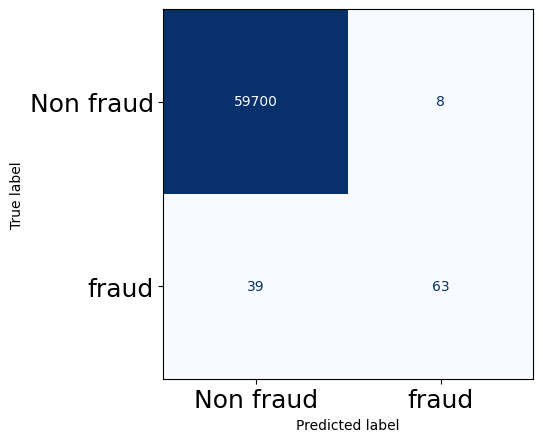

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

pipe.fit(X_train, y_train)
disp = ConfusionMatrixDisplay.from_estimator(
    pipe,
    X_valid,
    y_valid,
    display_labels=["Non fraud", "fraud"],
    values_format="d",
    cmap=plt.cm.Blues,
    colorbar=False,
);

![image.png](attachment:image.png)

- Perfect prediction has all values down the diagonal
- Off diagonal entries can often tell us about what is being mis-predicted

### What is "positive" and "negative"?

- Two kinds of binary classification problems
    - Distinguishing between two classes
    - Spotting a class (spot fraud transaction, spot spam, spot disease)
- In case of spotting problems, the thing that we are interested in spotting is considered "positive".
- Above we wanted to spot fraudulent transactions and so they are "positive".

### Confusion matrix with cross-validation

- You can also calculate confusion matrix with cross-validation using the `cross_val_predict` method.  
- But then you cannot conveniently use `plot_confusion_matrix`.

In [ ]:
from sklearn.model_selection import cross_val_predict

confusion_matrix(y_train, cross_val_predict(pipe, X_train, y_train))

array([[139296,     21],
       [    94,    143]], dtype=int64)

## Precision, recall, f1 score

- We have been using `.score` to assess our models, which returns accuracy by default.
- Accuracy is misleading when we have class imbalance.
- We need other metrics to assess our models.

- We'll discuss three commonly used metrics which are based on confusion matrix:
    - recall
    - precision
    - f1 score
- Note that these metrics will only help us assessing our model.  
- Later we'll talk about a few ways to address class imbalance problem.

In [ ]:
from sklearn.metrics import confusion_matrix

pipe_lr = make_pipeline(StandardScaler(), LogisticRegression())
pipe_lr.fit(X_train, y_train)
predictions = pipe_lr.predict(X_valid)
TN, FP, FN, TP = confusion_matrix(y_valid, predictions).ravel()
print(disp.confusion_matrix)

[[59700     8]
 [   38    64]]


### Recall

Among all positive examples, how many did you identify?
$$ recall = \frac{TP}{TP+FN} = \frac{TP}{\#positives} $$

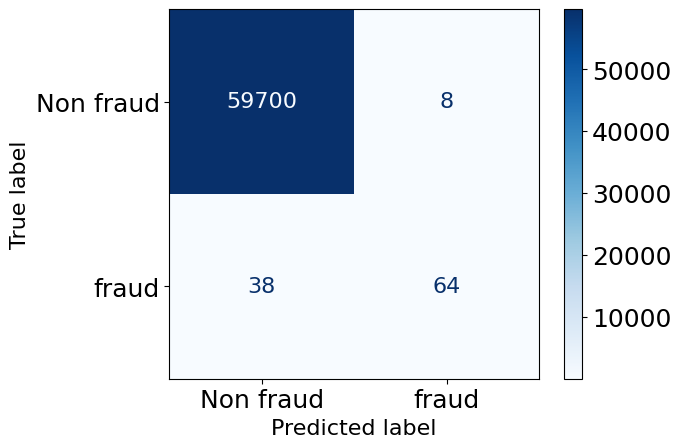

In [ ]:
ConfusionMatrixDisplay.from_estimator(
    pipe,
    X_valid,
    y_valid,
    display_labels=["Non fraud", "fraud"],
    values_format="d",
    cmap=plt.cm.Blues,
);

In [ ]:
print("TP = %0.4f, FN = %0.4f" % (TP, FN))
recall = TP / (TP + FN)
print("Recall: %0.4f" % (recall))

TP = 64.0000, FN = 38.0000
Recall: 0.6275


### Precision

Among the positive examples you identified, how many were actually positive?

$$ precision = \frac{TP}{TP+FP}$$

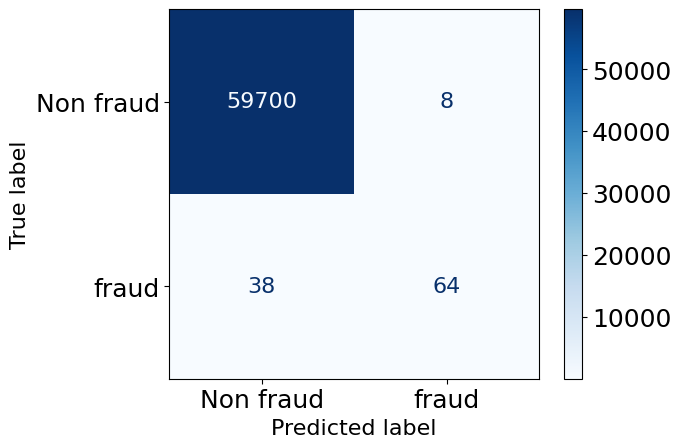

In [ ]:
ConfusionMatrixDisplay.from_estimator(
    pipe,
    X_valid,
    y_valid,
    display_labels=["Non fraud", "fraud"],
    values_format="d",
    cmap=plt.cm.Blues,
);

In [ ]:
print("TP = %0.4f, FP = %0.4f" % (TP, FP))
precision = TP / (TP + FP)
print("Precision: %0.4f" % (precision))

TP = 64.0000, FP = 8.0000
Precision: 0.8889


### F1-score

- F1-score combines precision and recall to give one score, which could be used in hyperparameter optimization, for instance.
- F1-score is a harmonic mean of precision and recall.


$$ f1 = 2 \times \frac{ precision \times recall}{precision + recall}$$


In [ ]:
print("precision: %0.4f" % (precision))
print("recall: %0.4f" % (recall))
f1_score = (2 * precision * recall) / (precision + recall)
print("f1: %0.4f" % (f1_score))

precision: 0.8889
recall: 0.6275
f1: 0.7356


Let's look at all metrics at once on our dataset.

In [ ]:
## Calculate evaluation metrics by ourselves
data = {
    "calculation": [],
    "accuracy": [],
    "error": [],
    "precision": [],
    "recall": [],
    "f1 score": [],
}
data["calculation"].append("manual")
data["accuracy"].append((TP + TN) / (TN + FP + FN + TP))
data["error"].append((FP + FN) / (TN + FP + FN + TP))
data["precision"].append(precision)  # TP / (TP + FP)
data["recall"].append(recall)  # TP / (TP + FN)
data["f1 score"].append(f1_score)  # (2 * precision * recall) / (precision + recall)
df = pd.DataFrame(data)
df

,calculation,accuracy,error,precision,recall,f1 score
0,manual,0.999231,0.000769,0.888889,0.627451,0.735632


- `scikit-learn` has functions for [these metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics).

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

data["accuracy"].append(accuracy_score(y_valid, pipe_lr.predict(X_valid)))
data["error"].append(1 - accuracy_score(y_valid, pipe_lr.predict(X_valid)))
data["precision"].append(
    precision_score(y_valid, pipe_lr.predict(X_valid), zero_division=1)
)
data["recall"].append(recall_score(y_valid, pipe_lr.predict(X_valid)))
data["f1 score"].append(f1_score(y_valid, pipe_lr.predict(X_valid)))
data["calculation"].append("sklearn")
df = pd.DataFrame(data)
df.set_index(["calculation"])

,accuracy,error,precision,recall,f1 score
calculation,,,,,
manual,0.999231,0.000769,0.888889,0.627451,0.735632
sklearn,0.999231,0.000769,0.888889,0.627451,0.735632


### Classification report

- There is a convenient function called `classification_report` in `sklearn` which gives this info.

In [ ]:
pipe_lr.classes_

array([0, 1], dtype=int64)

In [ ]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_valid, pipe_lr.predict(X_valid), target_names=["non-fraud", "fraud"]
    )
)

              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00     59708
       fraud       0.89      0.63      0.74       102

    accuracy                           1.00     59810
   macro avg       0.94      0.81      0.87     59810
weighted avg       1.00      1.00      1.00     59810



### Macro average

- You give equal importance to all classes and average over all classes.  
- For instance, in the example above, recall for non-fraud is 1.0 and fraud is 0.63, and so macro average is 0.81.
- More relevant in case of multi-class problems.    

### Weighted average

- Weighted by the number of samples in each class.
- Divide by the total number of samples.

Which one is relevant when depends upon whether you think each class should have the same weight or each sample should have the same weight.

### Example


In [ ]:
from sklearn.metrics import classification_report
y_true = [0, 1, 0, 1, 0]
y_pred = [0, 0, 0, 1, 0]
target_names = ['class 0', 'class 1']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.75      1.00      0.86         3
     class 1       1.00      0.50      0.67         2

    accuracy                           0.80         5
   macro avg       0.88      0.75      0.76         5
weighted avg       0.85      0.80      0.78         5



- weighted average is weighted by the proportion of examples in a particular class. So for the toy example above:
- weighted_average precision: 3/5 * 0.75 + 2/5 * 1.00 = 0.85
- weighted_average recall: 3/5 * 1.00 + 2/5 * 0.5 = 0.80
- weighted_average f1-score: 3/5 * 0.86 + 2/5 * 0.67 = 0.78

- macro average gives equal weight to both classes. So for the toy example above:
- macro average precision: 0.5 * 0.75 + 0.5 * 1.00 =0. 875
- macro average recall: 0.5 * 1.00 + 0.5 * 0.5 =0. 75
- macro average f1-score: 0.5 * 0.75 + 0.5 * 1.00 =0.765

## Insights:

- Accuracy is misleading when you have class imbalance.
- A confusion matrix provides a way to break down errors made by our model.
- We looked at three metrics based on confusion matrix:
    - precision, recall, f1-score.

- Note that what you consider "positive" (fraud in our case) is important when calculating precision, recall, and f1-score.
- If you flip what is considered positive or negative, we'll end up with different TP, FP, TN, FN, and hence different precision, recall, and f1-scores.

### Cross validation with different metrics

- We can pass different evaluation metrics with `scoring` argument of `cross_validate`.

In [ ]:
scoring = [
    "accuracy",
    "f1",
    "recall",
    "precision",
]  # scoring can be a string, a list, or a dictionary
pipe = make_pipeline(StandardScaler(), LogisticRegression())
scores = cross_validate(
    pipe, X_train_big, y_train_big, return_train_score=True, scoring=scoring
)
pd.DataFrame(scores)

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
0,0.556995,0.039999,0.999097,0.999360,0.694915,0.782979,0.602941,0.678967,0.820000,0.924623
1,0.556001,0.031000,0.999223,0.999317,0.739496,0.766595,0.647059,0.660517,0.862745,0.913265
2,0.556000,0.031999,0.999273,0.999216,0.743363,0.726477,0.617647,0.612546,0.933333,0.892473
3,0.547998,0.041000,0.999172,0.999254,0.697248,0.742981,0.558824,0.634686,0.926829,0.895833
4,0.549001,0.037000,0.999147,0.999216,0.696429,0.728850,0.582090,0.617647,0.866667,0.888889


**Select all of the following statements which are TRUE.**

- (A) In medical diagnosis, false positives are likely to be more damaging than false negatives (assume "positive" means the person has a disease, "negative" means they don't).
- (B) In spam classification, false positives are more damaging than false negatives (assume "positive" means the email is spam, "negative" means it's not).
- (C) If method A gets a higher accuracy than method B, that means its precision is also higher.
- (D) If method A gets a higher accuracy than method B, that means its recall is also higher.

Method A - higher accuracy but lower precision

| Negative | Positive
| -------- |:-------------:|
| 90      | 5|
| 5      | 0|

Method B - lower accuracy but higher precision

| Negative | Positive
| -------- |:-------------:|
| 80      | 15|
| 0      | 5|

